Import Necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df_customers = pd.read_csv('datasets/customers.csv')
df_trans = pd.read_csv('datasets/transactions.csv')
df_customers.isna().sum()

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/customers.csv'

Treating the null values for annual income (replace with median)

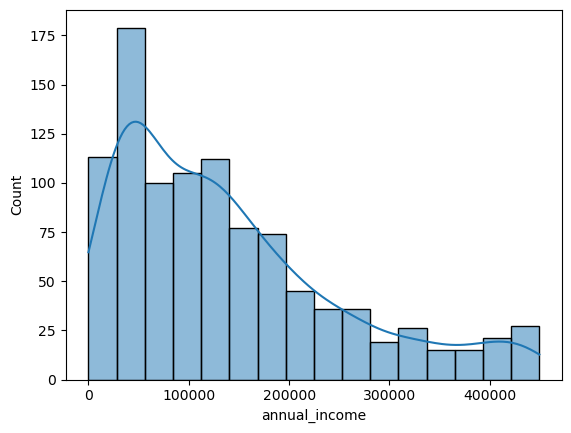

In [ ]:
df_customers['annual_income'] = df_customers.groupby('occupation')['annual_income'].transform(lambda x: x.fillna(x.median()))
df_customers.isna().sum()
sns.histplot(df_customers['annual_income'], kde=True)
plt.show()

Tackling Outliers in annual income (basically replace any value < 100 with the median of that particular occupation)

In [ ]:
occupation_median_income = df_customers.groupby('occupation')['annual_income'].median()
occupation_median_income

occupation
Accountant              65265.0
Artist                  45794.0
Business Owner         261191.5
Consultant              58017.0
Data Scientist         135759.0
Freelancer              46759.0
Fullstack Developer     76774.0
Name: annual_income, dtype: float64

In [ ]:
def apply_income(row):
    if row['annual_income'] < 100:    
        return occupation_median_income[row['occupation']]
    else:
        return row['annual_income']

df_customers['annual_income'] = df_customers.apply(apply_income, axis=1)

Data visualisation for categorical_columns = ['gender', 'location', 'occupation', 'marital_status']

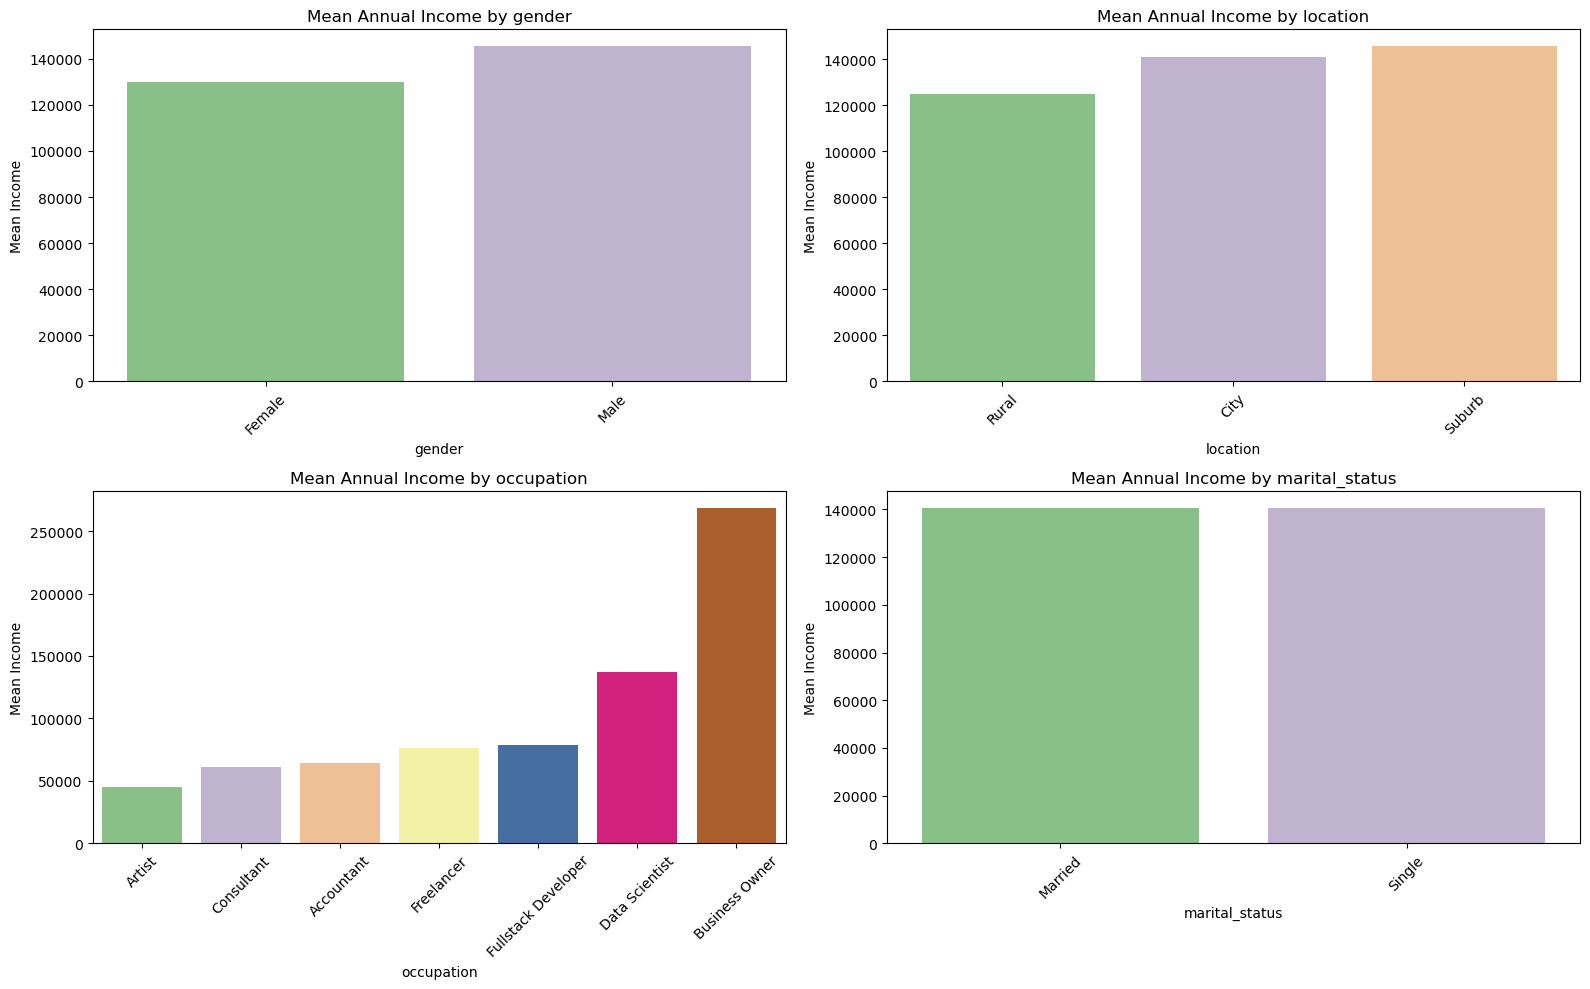

In [ ]:
categorical_columns = ['gender', 'location', 'occupation', 'marital_status']

# Create subplots: 2 rows, 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = axes.flatten()  # Flatten to easily loop

for idx, col in enumerate(categorical_columns):
    mean_per_category = (
        df_customers.groupby(col)['annual_income']
        .mean()
        .sort_values()
    )

    sns.barplot(
        ax=axes[idx],
        x=mean_per_category.index,
        y=mean_per_category.values,
        hue=mean_per_category.index,
        legend=False,
        palette='Accent'
    )

    axes[idx].set_title(f'Mean Annual Income by {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Mean Income')
    axes[idx].tick_params(axis='x', rotation=45)

# Remove any unused subplots if fewer than total
for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Treat Outliers in Age column

In [ ]:
df_customers['age'].describe()
invalid_age_count = ((df_customers['age'] < 15) | (df_customers['age'] > 80)).sum()
# we get 20 such entries
median_age_occupation = df_customers.groupby('occupation')['age'].median()
median_age_occupation

occupation
Accountant             31.5
Artist                 26.0
Business Owner         51.0
Consultant             46.0
Data Scientist         32.0
Freelancer             24.0
Fullstack Developer    27.5
Name: age, dtype: float64

In [ ]:
# apply median age by occuation to the values > 80 and < 15
def apply_age(row):
    if row['age'] < 15 or row['age'] > 80:
        return median_age_occupation[row['occupation']]
    else:
        return row['age']

df_customers['age'] = df_customers.apply(apply_age, axis = 1)
df_customers['age'].describe()

count    1000.000000
mean       35.541500
std        12.276634
min        18.000000
25%        26.000000
50%        32.000000
75%        44.250000
max        64.000000
Name: age, dtype: float64

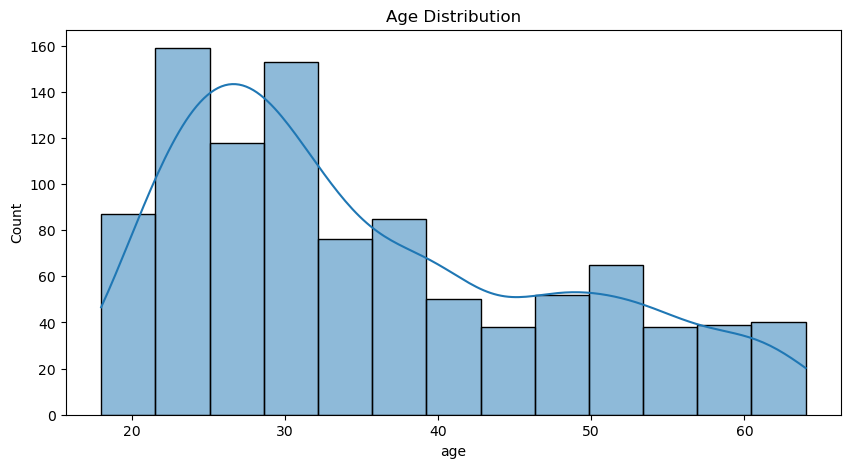

In [ ]:
# visualise age distribution

plt.figure(figsize=(10, 5))
sns.histplot(df_customers['age'],kde=True)
plt.title("Age Distribution")
plt.show()

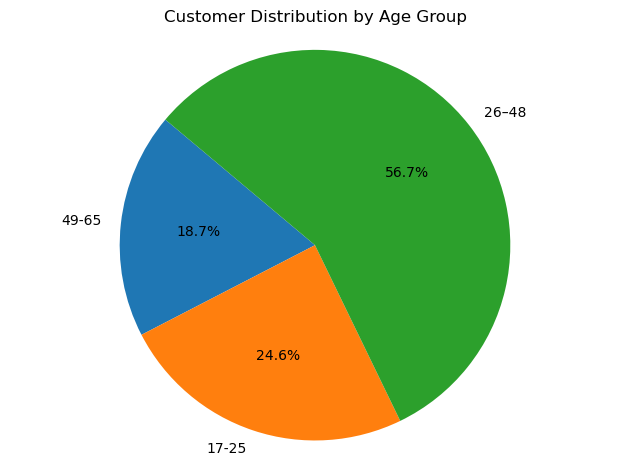

In [ ]:
# age group analysis
bins = [17, 25, 48, 65]
labels = ['17-25', '26–48', '49-65']

df_customers['age_group'] = pd.cut(df_customers['age'], bins=bins, labels=labels, right=True)
age_group_counts = df_customers['age_group'].value_counts().sort_values()


plt.pie(age_group_counts, labels=age_group_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Customer Distribution by Age Group')
plt.axis('equal')  # Ensures pie is a circle
plt.tight_layout()
plt.show()


location and gender distribution

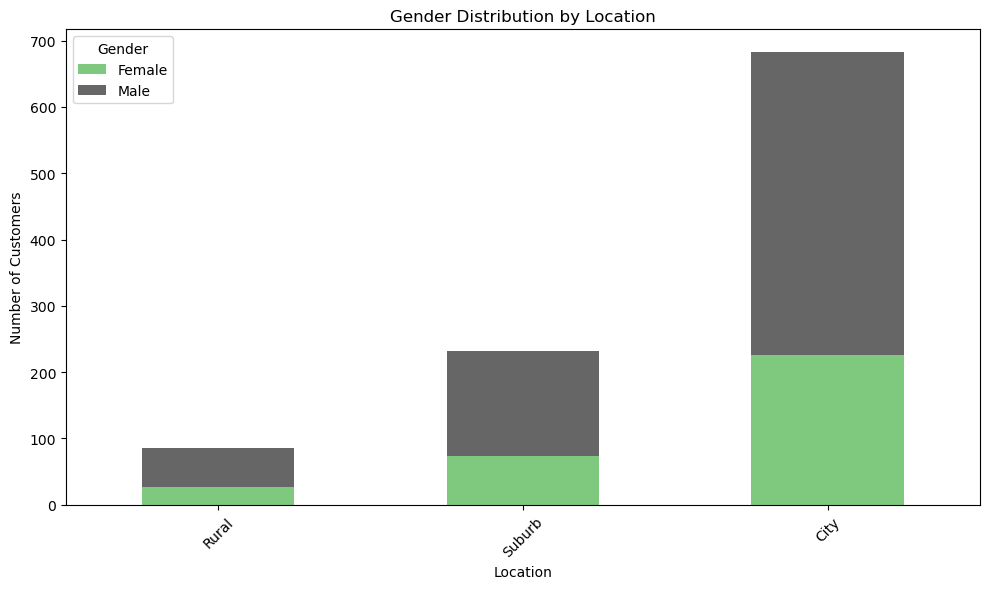

In [ ]:
# crosstab showing location and gender distribution
location_gender_distribution = pd.crosstab(df_customers['location'], df_customers['gender'])
# sort based on count
location_gender_distribution = location_gender_distribution.loc[
    location_gender_distribution.sum(axis=1).sort_values().index
]
# plot a stacked bar chart
location_gender_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Accent')
plt.title('Gender Distribution by Location')
plt.xlabel('Location')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

Explore Credit Score Table

In [ ]:
df_cs = pd.read_csv('datasets/credit_profiles.csv')
# remove duplicate records
duplicates = df_cs[df_cs['cust_id'].duplicated(keep=False)]
df_cs = df_cs.drop_duplicates(subset='cust_id', keep='last')
df_cs.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


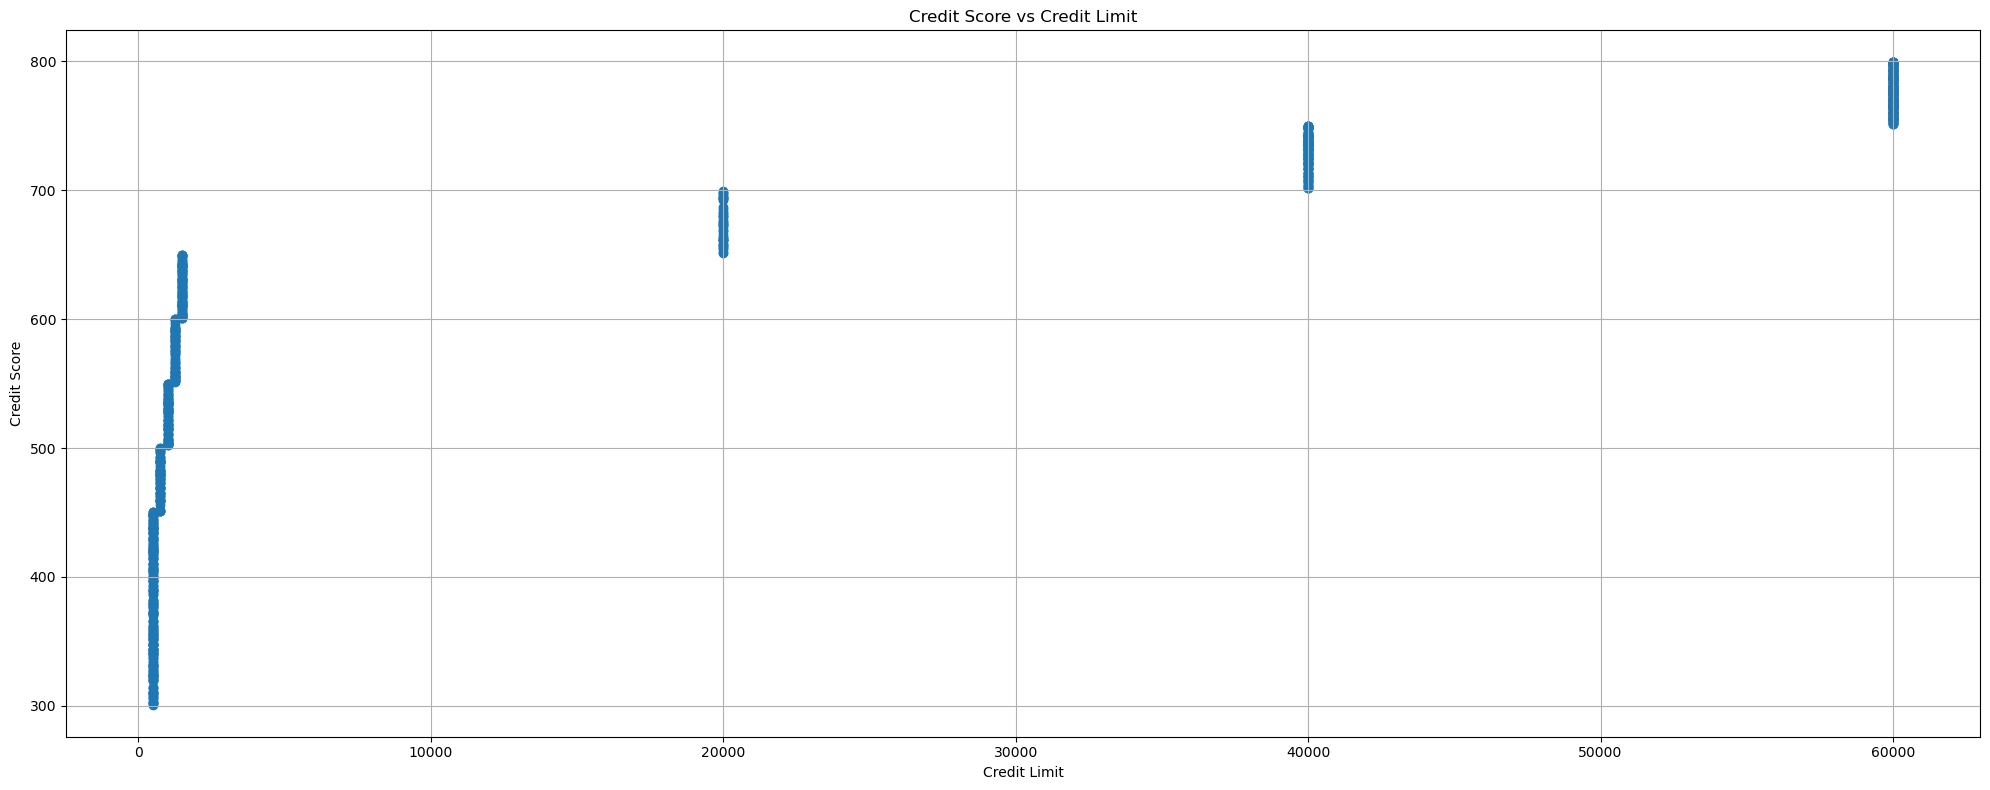

In [ ]:
# check for null values
df_cs[df_cs.credit_limit.isnull()]
# fill the na values
df_cs.credit_limit.value_counts()
# show the relation between credit_score and credit_limit
plt.figure(figsize=(20, 8))
plt.scatter(df_cs.credit_limit, df_cs.credit_score)
plt.title('Credit Score vs Credit Limit')
plt.xlabel('Credit Limit')
plt.ylabel('Credit Score')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# credit score range
credit_bins = [300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]
credit_labels = [f"{credit_bins[i]}–{credit_bins[i+1]-1}" for i in range(len(credit_bins)-1)]

df_cs['credit_score_range'] = pd.cut(
    df_cs['credit_score'],
    bins=credit_bins,
    labels=credit_labels,
    include_lowest=True,
    right=False  # Makes bins left-inclusive, right-exclusive
)

# Step 1: Mode per credit score range → as DataFrame
credit_limit_modes_df = df_cs.groupby('credit_score_range', observed=True)['credit_limit'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
).reset_index().rename(columns={'credit_limit': 'mode_credit_limit'})

# Step 2: Merge with original data
df_cs = df_cs.merge(credit_limit_modes_df, on='credit_score_range', how='left')

# Step 3: Fill missing credit_limit with the mode
df_cs['credit_limit'] = df_cs['credit_limit'].fillna(df_cs['mode_credit_limit'])

# Step 4 (Optional): Drop the helper column
df_cs.drop(columns='mode_credit_limit', inplace=True)


In [ ]:
# removing outliers in outstanding_debt
df_cs.loc[df_cs['outstanding_debt'] > df_cs['credit_limit'], 'outstanding_debt'] = df_cs['credit_limit']


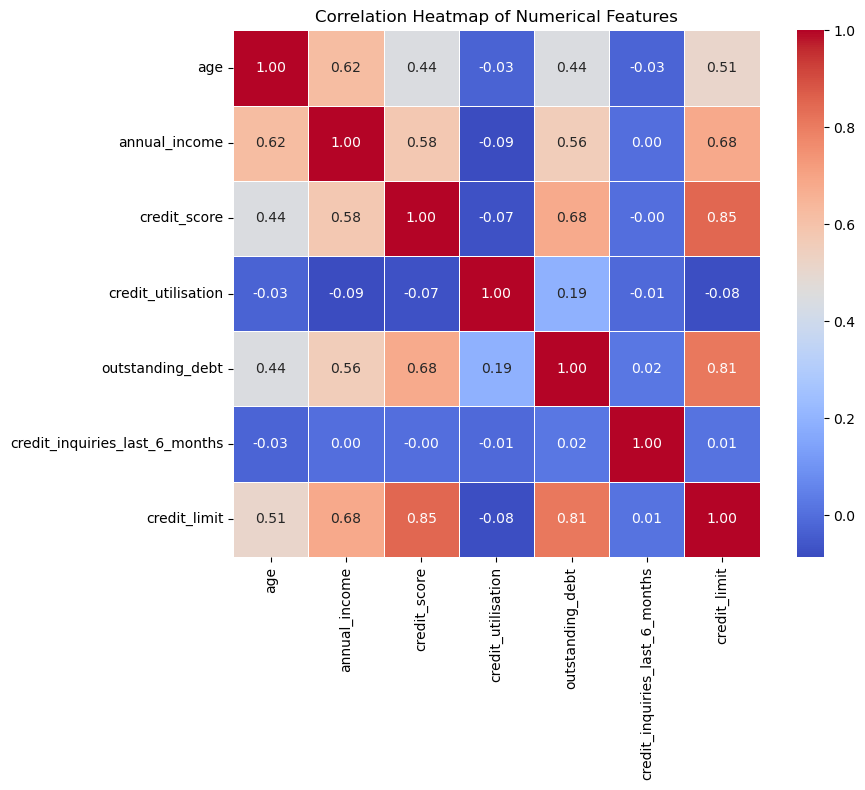

In [ ]:
# heat map to visualise relatiinship between variables (biwariate analysis)
df_merged = df_customers.merge(df_cs, how = 'inner', on ='cust_id')

numerical_columns = [
    "age",
    "annual_income",
    "credit_score",
    "credit_utilisation",
    "outstanding_debt",
    "credit_inquiries_last_6_months",
    "credit_limit"
]

correlation_matrix = df_merged[numerical_columns].corr()
correlation_matrix

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)

plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()



Transactions Data Analysis

In [ ]:
df_trans = pd.read_csv('datasets/transactions.csv')
# Step 1: Compute mode of platform per product category
platform_mode_df = df_trans.groupby('product_category', observed=True)['platform'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
).reset_index().rename(columns={'platform': 'platform_mode'})

# Step 2: Merge with the original dataframe
df_trans = df_trans.merge(platform_mode_df, on='product_category', how='left')

# Step 3: Fill missing platform values with the mode
df_trans['platform'] = df_trans['platform'].fillna(df_trans['platform_mode'])

# Step 4: Drop the helper column
df_trans.drop(columns='platform_mode', inplace=True)

df_trans.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


In [ ]:
df_trans.describe()
# identify what to do with record having tran_amount = 0

df_trans_0 = df_trans[(df_trans.tran_amount > 0)&(df_trans.platform == 'Amazon') & (df_trans.product_category == 'Electronics')]
# all of these records have platform = Amazon and product_category as Electronics
median_trans_amount = df_trans_0.tran_amount.median()
df_trans.loc[
    (df_trans['tran_amount'] == 0) & 
    (df_trans['platform'] == 'Amazon') & 
    (df_trans['product_category'] == 'Electronics'),
    'tran_amount'
] = median_trans_amount


In [ ]:
# detect outliers using IQR (since the transactions dont follow a normal distribution)
Q1, Q3 = df_trans.tran_amount.quantile([0.25, 0.75])
IQR = Q3 - Q1
# ideally we use +- 1.5*IQR, but here we are using 2*IQR
lower_bound, upper_bound = Q1 - 2*IQR, Q3 + 2*IQR

outliers = (df_trans['tran_amount'] < lower_bound) | (df_trans['tran_amount'] > upper_bound)
df_trans_normal = df_trans[(df_trans['tran_amount'] >= lower_bound) & (df_trans['tran_amount'] <= upper_bound)]
# calculate mean transcation amount per product category
trans_normal_mean_map = round(df_trans_normal.groupby('product_category')['tran_amount'].mean(), 2)

df_trans.loc[outliers, 'tran_amount'] = df_trans.loc[outliers, 'product_category'].map(trans_normal_mean_map)


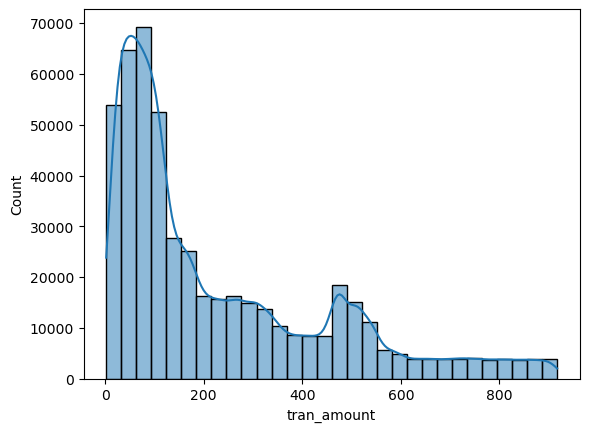

In [ ]:
# hist plot showing transactions distribution
sns.histplot(df_trans.tran_amount, kde=True, bins=30)
plt.show()

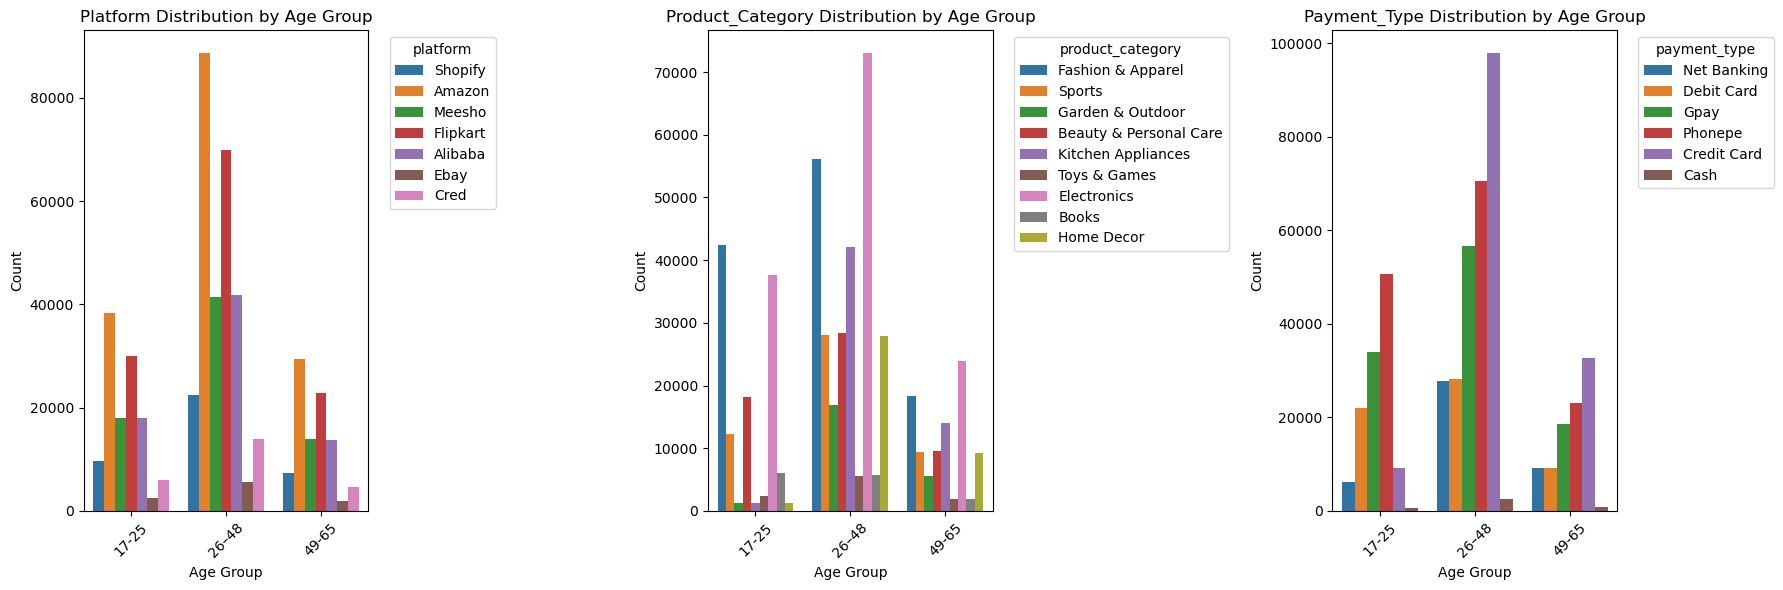

In [ ]:
# count plot analysis for (platform, product_categor and payment_type)
df_final_merged = pd.merge(df_merged, df_trans, on='cust_id', how = 'inner')


# Columns to analyze
cat_columns = ['platform', 'product_category', 'payment_type']

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot each countplot
for i, col in enumerate(cat_columns):
    sns.countplot(data=df_final_merged, x='age_group', hue=col, ax=axes[i])
    axes[i].set_title(f'{col.title()} Distribution by Age Group')
    axes[i].set_xlabel('Age Group')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()

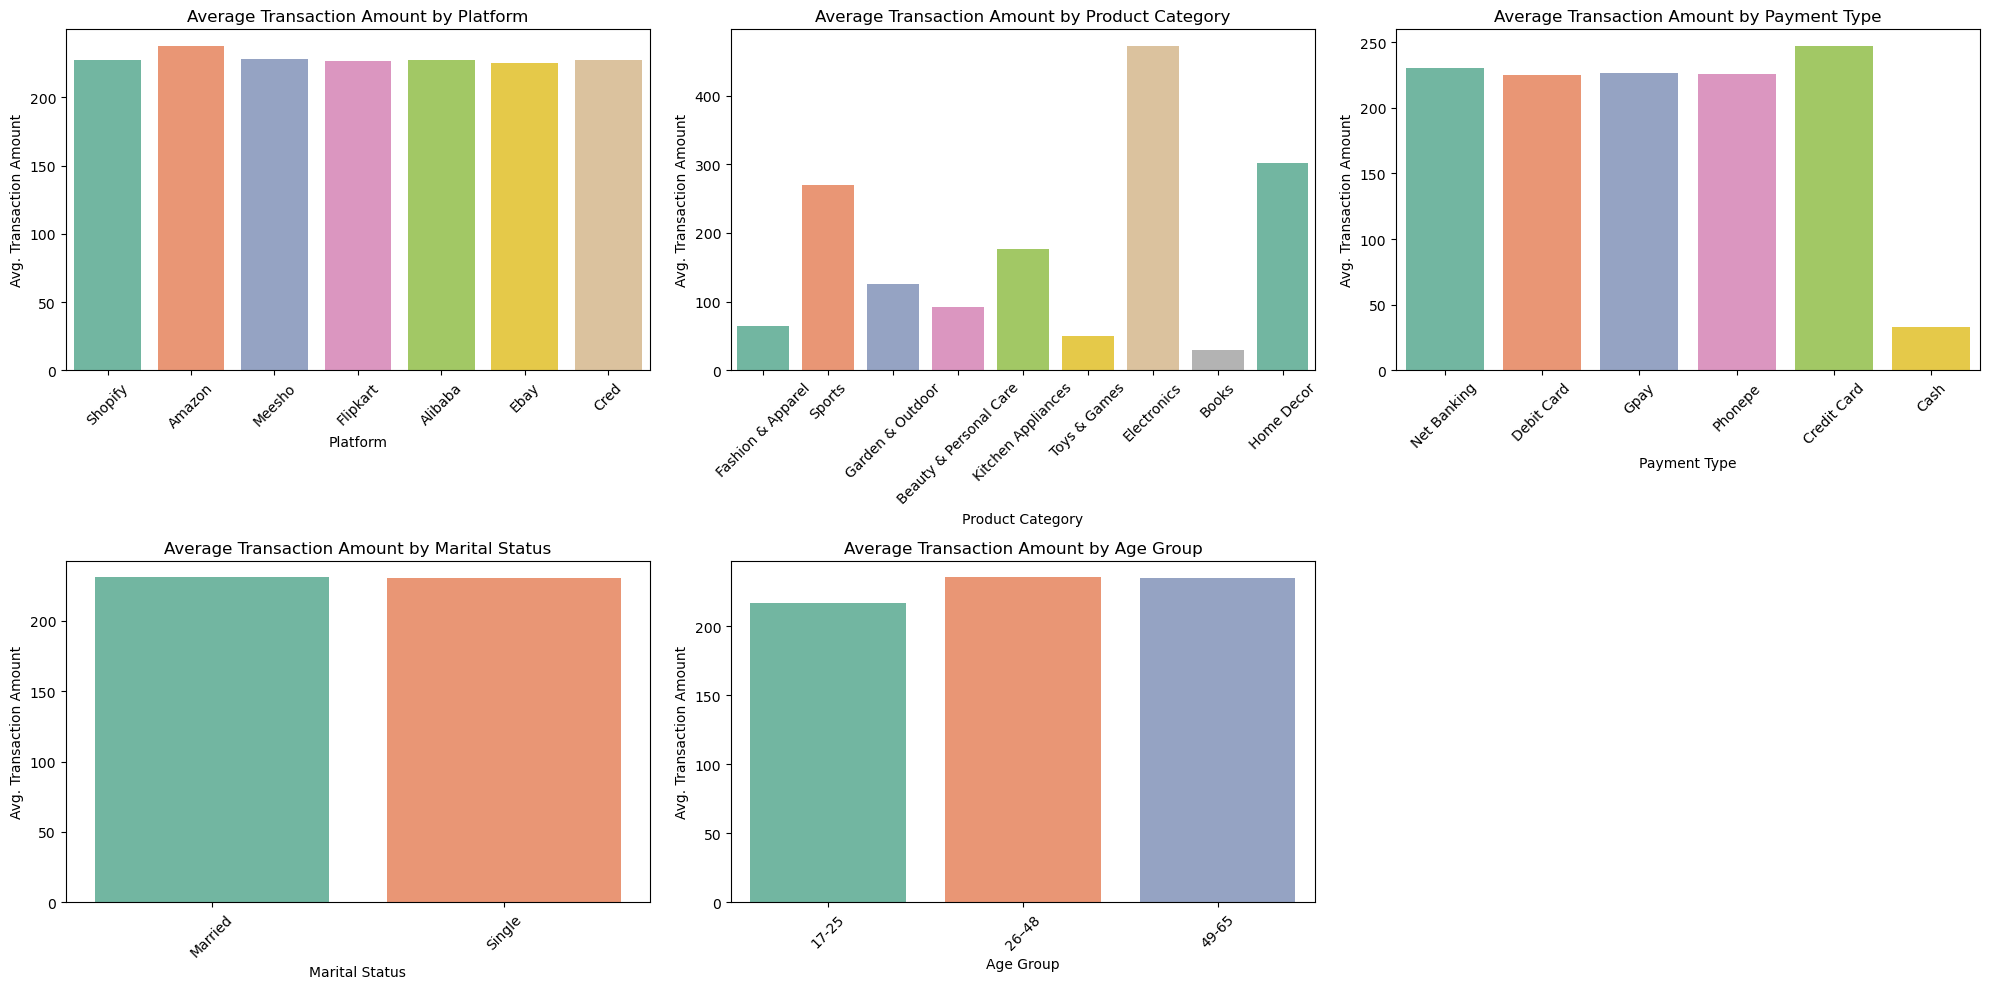

In [ ]:
group_columns = ['platform', 'product_category', 'payment_type', 'marital_status', 'age_group']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(group_columns):
    sns.barplot(
    data=df_final_merged,
    x=col,
    y='tran_amount',
    hue=col,              
    legend=False,       
    ax=axes[i],
    estimator='mean',
    errorbar=None,
    palette='Set2'
)
    axes[i].set_title(f'Average Transaction Amount by {col.replace("_", " ").title()}')
    axes[i].set_xlabel(col.replace("_", " ").title())
    axes[i].set_ylabel('Avg. Transaction Amount')
    axes[i].tick_params(axis='x', rotation=45)

# Remove the 6th empty subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

<h2 align="center" style="color:purple">Phase 2: AtliQ0 Bank Credit Card Project</h2>


### Business Analysis and launch of AB testing: Targeting Untapped Market

### Insights specific to customers with age group of 18 - 25
1. People with age group of 18 -25 accounts to ~25% of customer base in the data
2. Avg annual income of this age group is less than 50k
3. They don't have much credit history which is getting reflected in their credit score and max credit limit 
4. Usage of credit cards as payment type is relatively low compared to other groups
5. Avg transaction amount made with credit cards is also low compared to other groups
5. Top 3 most used shopping products categories  : Electronics, Fashion & Apparel, Beauty & Personal care

![Analysis Image](analysis.png)

## (1) Pre-Campaign

We want to do a trial run for our new credit card. For this we need to figure out (1) How many customers do we need for our A/B testing. We will form a control and test group. For both of these groups we can figure out number of customers we need based on the statistical power and effect size that we agree upon after discussing with business. We will use 

In [ ]:
#import required libraries
import statsmodels.stats.api as sms
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [ ]:
# Calculate the required sample size for different effect sizes
alpha = 0.05
power = 0.8
effect_sizes = [0.1, 0.2, 0.3, 0.4, 0.5,1]  #  standard deviations greater than control group 

for effect_size in effect_sizes:
    sample_size = sms.tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1, alternative='two-sided')
    print(f"Effect Size: {effect_size}, Required Sample Size: {int(sample_size)} customers")

Effect Size: 0.1, Required Sample Size: 1570 customers
Effect Size: 0.2, Required Sample Size: 393 customers
Effect Size: 0.3, Required Sample Size: 175 customers
Effect Size: 0.4, Required Sample Size: 99 customers
Effect Size: 0.5, Required Sample Size: 63 customers
Effect Size: 1, Required Sample Size: 16 customers


Based on business requirements, the test should be capable of detecting a minimum 0.4 standard deviation difference between the control and test groups. For the effect size 0.4, we need 100 customers and when we discussed with business, 100 customers is ok in terms of their budgeting constraints for this trail run

#### Forming control and test groups

1.We have identified approximately 246 customers within the age group of 18 to 25. From this pool, we will select 100 customers for the initial campaign launch.

2.The campaign is launched for 100 customers, as determined by the effective size calculation and by considering budgeting costs, and will run campaign for a duration of 2 months

3.Got a conversion rate of ~40% ( implies 40 out of 100 customers in test group started using credit card)

4.To maintain a similar sample size, a control group consisting of 40 customers will be created. Importantly, this control group will be completely exclusive of initial 100 customers used as test group.

5.So now we have 40 customers in each of control and test groups

##### At the end of the 2-month campaign period (from 09-10-23 to 11-10-23), we obtained daily data showing the average transaction amounts made by the entire group of 40 customers in both the control and test groups using existing and newly launched credit cards respectively

##### The key performance indicator (KPI) for this AB test aims to enhance average transaction amounts facilitated by the new card

In [ ]:
df_campaign = pd.read_csv('avg_transactions_after_campaign.csv')
df.head()

,campaign_date,control_group_avg_tran,test_group_avg_tran
0,2023-09-10,259.83,277.32
1,2023-09-11,191.27,248.68
2,2023-09-12,212.41,286.61
3,2023-09-13,214.92,214.85
4,2023-09-14,158.55,344.08


In [ ]:
control_mean = round(df_campaign.control_group_avg_tran.mean(),2)
control_std = round(df_campaign.control_group_avg_tran.std(),2)

control_mean, control_std

(221.18, 21.36)

In [ ]:
test_mean = round(df_campaign.test_group_avg_tran.mean(),2)
test_std = round(df_campaign.test_group_avg_tran.std(),2)
test_mean, test_std

(235.98, 36.66)

In [ ]:
sample_size = df_campaign.shape[0]
sample_size

62

In [ ]:
z_critical = norm.ppf(1 - alpha)

a = control_std**2/sample_size
b = test_std**2 / sample_size
z_score = (test_mean - control_mean) / (np.sqrt(a + b))
z_score

2.7466072001806734

In [ ]:
# Since Z score is higher than critical Z value, we can reject the null hypothesis. So our new credit card is actiually performing better